# Human Segmentation with DeepLabV3+

<p>Matheus Schmitz<br>
<a href="https://www.linkedin.com/in/matheusschmitz/">LinkedIn</a><br>
<a href="https://matheus-schmitz.github.io/">Github Portfolio</a></p>

https://arxiv.org/pdf/1802.02611.pdf

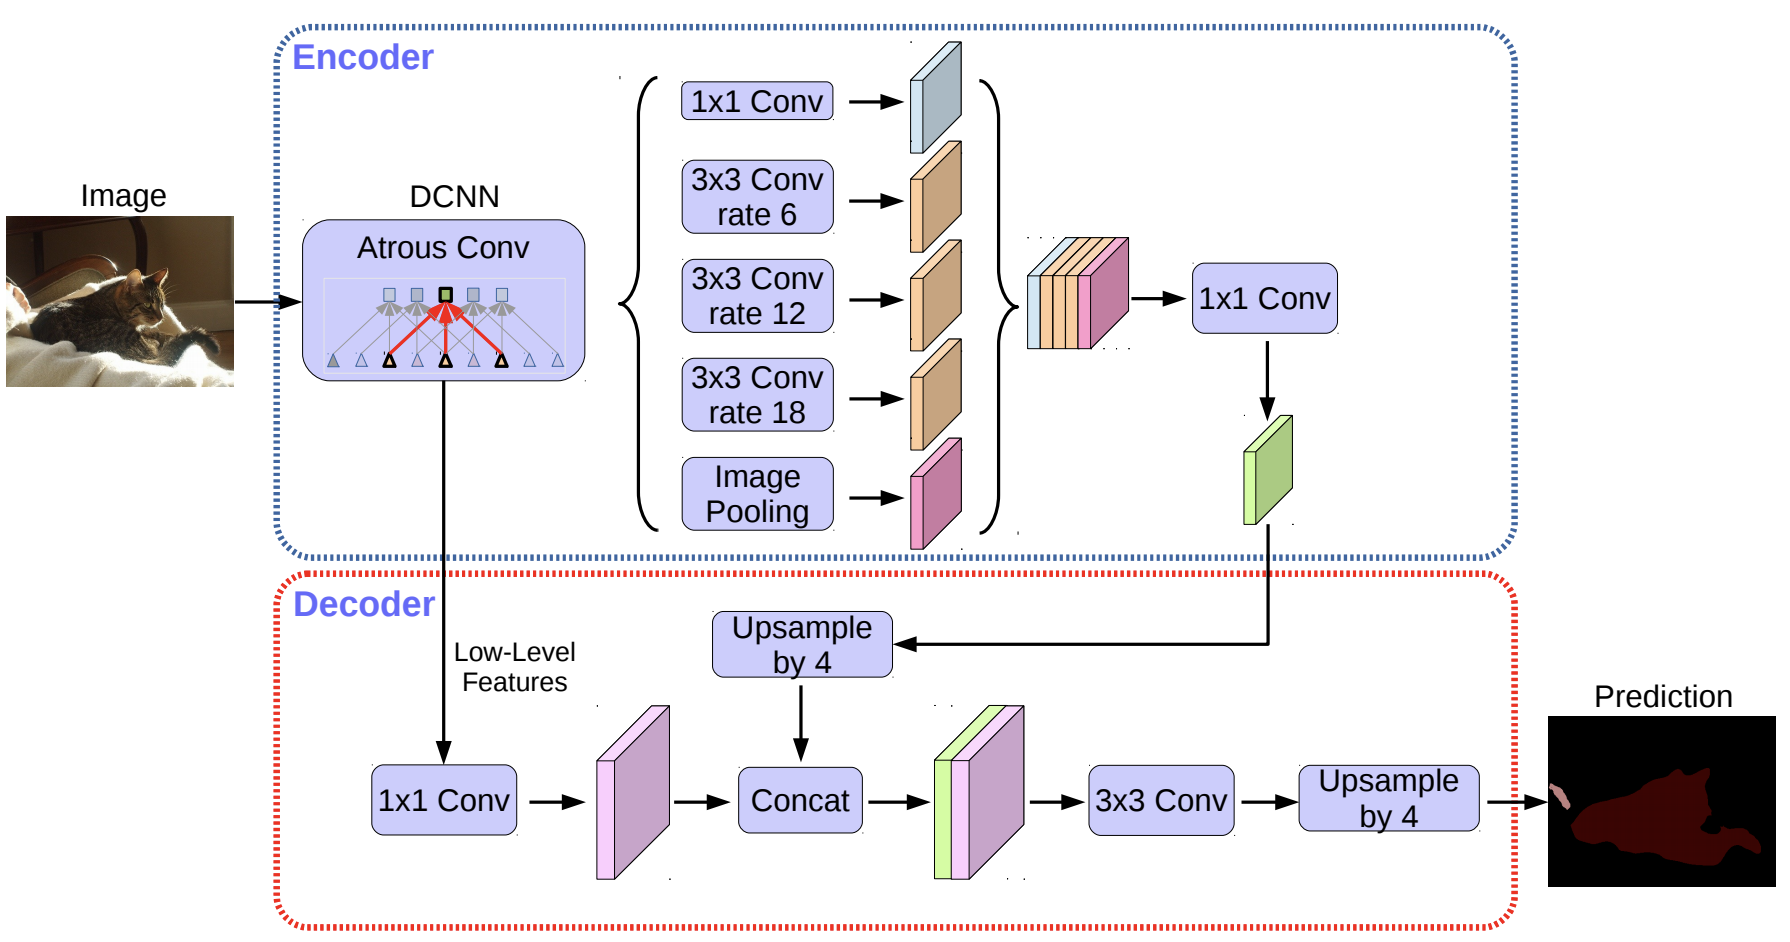

Data source: https://www.kaggle.com/datasets/nikhilroxtomar/person-segmentation?resource=download

## Connect to Google Colab

In [1]:
# File manipulation imports for Google Colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/DeepLabV3+_Human_Segmentation/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Config

In [2]:
!pip install --quiet tensorflow-addons tensorflow-model-optimization

In [3]:
RANDOM_SEED = 0
H, W = 512, 512
EPSILON_SMOOTHENING = 1e-15
BATCH_SIZE = 4
LEARNING_RATE = 1e-3
NUM_EPOCS = 5
AUGMENTATION_PATH = 'augmented_data/'
MODEL_PATH = "checkpoint/model.h5"
CSV_PATH = "checkpoint/training_log.csv"

# Data

In [4]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import albumentations as A

In [5]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
def load_data(path, split=0.1):
    X = sorted(glob(os.path.join(path, "images", "*.jpg")))
    Y = sorted(glob(os.path.join(path, "masks", "*.png")))
    assert len(X) == len(Y), 'Images and Masks do not match'

    split_size = int(len(X) * split)

    train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=split_size, random_state=RANDOM_SEED)
    return train_x, test_x, train_y, test_y

In [7]:
def augment_data(images, masks, save_path, augment=True):
    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split('/')[-1].split('.')[0]
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        if augment:
            aug = A.HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            aug = A.Rotate(limit=45, p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            aug = A.Rotate(limit=45, p=1.0)
            augmented = aug(image=x2, mask=y2)
            x4 = augmented['image']
            y4 = augmented['mask']

            X = [x, x2, x3, x4]
            Y = [y, y2, y3, y4]

        else:
            X = [x]
            Y = [y]

        for idx, (x, y) in enumerate(zip(X, Y)):
            try:
                aug = A.CenterCrop(H, W, p=1.0)
                augmented = aug(image=x, mask=y)
                x = augmented['image']
                y = augmented['mask']

            # Some images are smaller than 512x512 so can't CenterCrop
            except:
                x = cv2.resize(x, (H, W))
                y = cv2.resize(y, (H, W))

            tmp_image_name = f"{name}_{idx}.png"
            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_image_name)
            cv2.imwrite(image_path, x)
            cv2.imwrite(mask_path, y)

In [8]:
def main():
    np.random.seed(RANDOM_SEED)

    # Load data
    data_path = "people_segmentation"
    train_x, test_x, train_y, test_y = load_data(data_path)

    # Create directories to save the augmented data
    for parent_dir in ['train', 'test']:
        for child_dir in ['image', 'mask']:
            create_dir(AUGMENTATION_PATH + '/' + parent_dir + '/' + child_dir)

    # Data augmentation
    augment_data(train_x, train_y, "./augmented_data/train/", augment=True)
    augment_data(test_x, test_y, "./augmented_data/test", augment=False)

In [9]:
#main()

## Model

In [10]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense, Dropout, Flatten
from tensorflow.keras.layers import LayerNormalization
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

In [11]:
def SqueezeAndExcite(inputs, ratio=8):
    '''
    Generate per-channel attention maps for reweighting
    https://arxiv.org/pdf/1709.01507.pdf
    '''
    init = inputs
    filters = init.shape[-1]
    se = GlobalAveragePooling2D()(init)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters//ratio, activation='swish', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='swish', kernel_initializer='he_normal', use_bias=False)(se)
    x = init * se
    return x

In [12]:
def AtrousSpatialPyramidPooling(inputs):
    """ 
    Applies several parallel atrous convolution with different rates
    https://arxiv.org/pdf/1802.02611.pdf
    """

    # Image Pooling
    shape = inputs.shape # (B, H, W, C) → default is channels last
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs) # (B, 1, 1, 3)
    y1 = Conv2D(256, kernel_size=1, padding="same", use_bias=False)(y1) # (B, 1, 1, 256)
    y1 = BatchNormalization()(y1)
    y1 = Activation("swish")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1) # (B, H, W, 256)

    # 1x1 Conv | Rate = 1
    y2 = Conv2D(256, kernel_size=1, padding="same", use_bias=False)(inputs) # (B, H, W, 256)
    y2 = BatchNormalization()(y2)
    y2 = Activation("swish")(y2)

    # 3x3 Conv | Rate = 6
    y3 = Conv2D(256, kernel_size=3, padding="same", use_bias=False, dilation_rate=6)(inputs) # (B, H, W, 256)
    y3 = BatchNormalization()(y3)
    y3 = Activation("swish")(y3)  

    # 3x3 Conv | Rate = 12
    y4 = Conv2D(256, kernel_size=3, padding="same", use_bias=False, dilation_rate=12)(inputs) # (B, H, W, 256)
    y4 = BatchNormalization()(y4)
    y4 = Activation("swish")(y4)  

    # 3x3 Conv | Rate = 8
    y5 = Conv2D(256, kernel_size=3, padding="same", use_bias=False, dilation_rate=18)(inputs) # (B, H, W, 256)
    y5 = BatchNormalization()(y5)
    y5 = Activation("swish")(y5)  

    y = Concatenate()([y1, y2, y3, y4, y5]) # (B, H, W, 1280)
    y = Conv2D(256, kernel_size=1, padding="same", use_bias=False)(y) # (B, H, W, 256)
    y = BatchNormalization()(y)
    y = Activation("swish")(y)  

    return y

In [13]:
fake_input = tf.random.uniform(shape=(2,512,512,3))
fake_input.shape
fake_output = AtrousSpatialPyramidPooling(fake_input)
fake_output.shape

TensorShape([2, 512, 512, 256])

In [14]:
def deeplabv3_plus(shape):

    inputs = Input(shape)
    encoder = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

    # High level features for ASPP
    x_a = encoder.get_layer('conv4_block6_out').output # (B, 32, 32, 1024)
    x_a = tf.stop_gradient(x_a)
    x_a = AtrousSpatialPyramidPooling(x_a) # (B, 32, 32, 256)
    x_a = UpSampling2D((4, 4), interpolation='bilinear')(x_a) # (B, 128, 128, 256)

    # Low level features for skip connection
    x_b = encoder.get_layer('conv2_block2_out').output # (B, 128, 128, 256)
    x_b = tf.stop_gradient(x_b)
    x_b = Conv2D(48, kernel_size=1, padding='same', use_bias=False)(x_b) # (B, 128, 128, 48)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('swish')(x_b)

    x = Concatenate(axis=-1)([x_a, x_b]) # (B, 128, 128, 304)
    x = SqueezeAndExcite(x)

    x = Conv2D(256, kernel_size=3, padding='same', use_bias=False)(x) # (B, 128, 128, 256)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(256, kernel_size=3, padding='same', use_bias=False)(x) # (B, 128, 128, 256)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)   
    x = Dropout(0.1)(x)
    x = SqueezeAndExcite(x)

    x = UpSampling2D((4, 4), interpolation='bilinear')(x) # (B, 512, 512, 256)
    x = Conv2D(1, kernel_size=1)(x) # (B, 512, 512, 1)
    x = Activation('sigmoid')(x)

    model = Model(inputs, x)
    return model

In [15]:
model = deeplabv3_plus((512, 512, 3))

fake_input = tf.random.uniform(shape=(2,512,512,3))
fake_input.shape
fake_output = model(fake_input)
fake_output.shape

TensorShape([2, 512, 512, 1])

## Metrics

In [16]:
import numpy as np

In [17]:
def iou(y_true, y_pred):
    '''
    Pixel-wise IoU for segmantic segmentation masks
    Designed only for binary classification
    '''
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum() # 1 only if both have a mask at a given pixel
        union = y_true.sum() + y_pred.sum() - intersection # 1 for each masked pixel in each {truth, pred}, then remove the double counts by subtracting the intersection
        x = (intersection + EPSILON_SMOOTHENING) / (union + EPSILON_SMOOTHENING)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], Tout=tf.float32)

In [18]:
def dice_coef(y_true, y_pred):
    y_true = Flatten()(y_true)
    y_pred = Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + EPSILON_SMOOTHENING) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + EPSILON_SMOOTHENING)

In [19]:
def dice_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

## Train

In [20]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # shut-up Tensorflow!

import tensorflow as tf
from tensorflow_addons.optimizers import AdaBelief
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.metrics import Recall, Precision
import tensorflow_model_optimization as tfmot
import numpy as np
import cv2
from sklearn.utils import shuffle
from glob import glob

In [21]:
def load_augmented_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.png")))
    y = sorted(glob(os.path.join(path, "mask", "*.png")))
    return x, y

In [22]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x/255.
    return x.astype(np.float32)

In [23]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = np.expand_dims(x, axis=-1)
    return x.astype(np.float32)

In [24]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

In [25]:
def tf_dataset(X, Y, batch_size=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.shuffle(len(X), reshuffle_each_iteration=True, seed=RANDOM_SEED)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(8)
    return dataset

In [26]:
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [27]:
create_dir('checkpoint')

In [28]:
train_x, train_y = load_augmented_data(f'{AUGMENTATION_PATH}/train')
valid_x, valid_y = load_augmented_data(f'{AUGMENTATION_PATH}/test')

train_dataset = tf_dataset(train_x, train_y, batch_size=BATCH_SIZE)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size=BATCH_SIZE)

In [29]:
model = deeplabv3_plus((H, W, 3))
#model = tfmot.quantization.keras.quantize_model(model)
model.compile(loss=dice_loss, optimizer=AdaBelief(LEARNING_RATE), metrics=[dice_coef, iou, Recall(), Precision()])
model.load_weights('pretrained.h5')

In [30]:
callbacks = [
    ModelCheckpoint(MODEL_PATH, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(CSV_PATH),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
]

In [31]:
# model.fit(
#     train_dataset,
#     epochs=NUM_EPOCS,
#     validation_data=valid_dataset,
#     callbacks=callbacks
# )

## Predict

In [32]:
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope

In [33]:
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model("checkpoint/model.h5")

In [34]:
data_x = glob("test_images/image/*")

for path in tqdm(data_x, total=len(data_x)):
    
    # Get image name
    name = path.split("/")[-1].split(".")[0]

    # Read image
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    h, w, _ = image.shape
    x = cv2.resize(image, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)

    # Generate mask
    y = model.predict(x)[0]
    y = cv2.resize(y, (w, h))
    y = np.expand_dims(y, axis=-1)

    # Save Image
    masked_image = image * y
    line = np.ones((h, 10, 3)) * 128
    cat_images = np.concatenate([image, line, masked_image], axis=1)
    cv2.imwrite(f"test_images/mask/{name}.png", cat_images)

100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


# View Results

In [35]:
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [36]:
test_images = glob('test_images/mask/*.*')

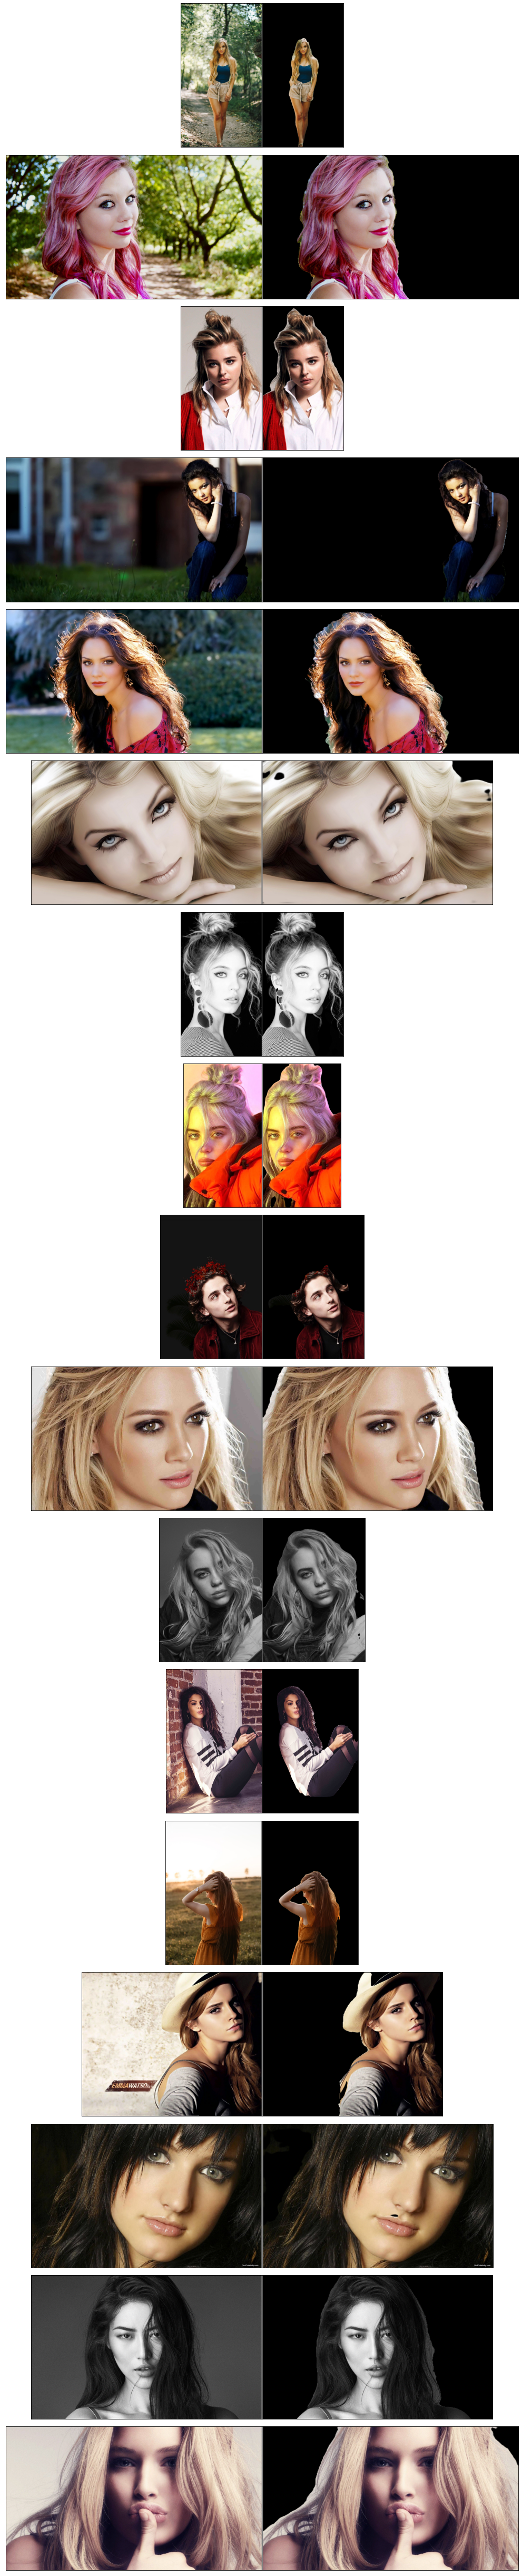

In [37]:
# Plot original images, tetra-chrome images, and images colored by the model
num_images = len(test_images)
fig, axs = plt.subplots(ncols=1, nrows=num_images, figsize=(20,num_images*4))

# Loop through axes and plot random images
for idx, axs_row in enumerate(range(axs.shape[0])):
    
    # Input
    img = mpimg.imread(test_images[idx])
    axs[axs_row].imshow(img)
    axs[axs_row].set_xticks([])  
    axs[axs_row].set_yticks([])

plt.tight_layout()

# End

<p>Matheus Schmitz<br>
<a href="https://www.linkedin.com/in/matheusschmitz/">LinkedIn</a><br>
<a href="https://matheus-schmitz.github.io/">Github Portfolio</a></p>